w:  -0.03618287925751117 score:  0.9061683404788985
w:  0.04716535418849114 score:  0.7988021887040437
w:  -0.010752020398161755 score:  0.7533804765155955
w:  0.1387577030812325 score:  0.9247837242432616


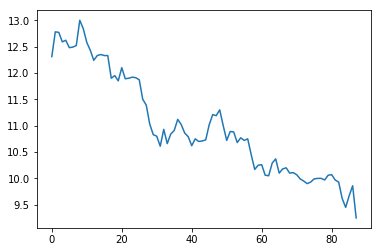

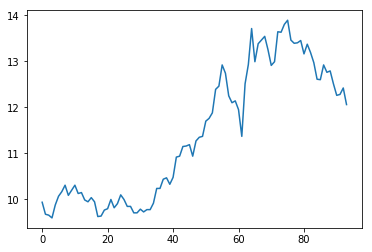

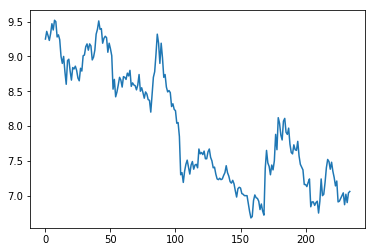

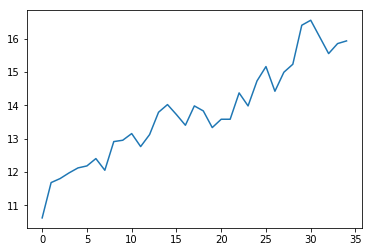

In [1]:
%matplotlib inline
#!usr/bin/env python
# -*- coding:utf-8 _*-

"""
@author: solinari
@file: test.py
@time: 2019/02/10
"""

import sys
import time
import numpy as np
import matplotlib.pyplot as plt

# sys.path.append('D:/workspace/test')
# sys.path.append('D:/workspace/stockCrawler')

# sys.path.append('/home/ubuntu/test')
# sys.path.append('/home/solinari/workspace/test')
# sys.path.append('/mnt/d/workspace/test')
# sys.path.append('/home/ubuntu/stockCrawler')
# sys.path.append('/home/solinari/workspace/stockCrawler')
# os.system("export PYTHONPATH=/home/ubuntu/stockCrawler:/home/solinari/workspace/stockCrawler:%PYTHONPATH")
# os.system("export PYTHONPATH=/home/ubuntu/test:/home/solinari/workspace/test:%PYTHONPATH")
# paths = os.getcwd().split('/')
# del(paths[len(paths)-2])
# del(paths[len(paths)-1])
# _path = os.path.join(paths)
# print (_path)

from pytorch.sklearn_lineregression import do_regression
from datamanager.collection import collection
from datamanager.collection import data_show
import torch
from torch.autograd import Variable
from torch_learning.tensorboardX_002 import TBwriter



if __name__ == '__main__':
    c = collection.Collection()

    for result in c.getData(code="600000", start_date="2000-01-01", end_date="2010-12-31"):
        ret = do_regression(result, epochs=10000, thres=10,
                            DBSCAN_eps=3, DBSCAN_minsamples=4)
        for item in ret:
            w = item[0]
            b = item[1]
            score = item[4]

            # if line regression cov score < xx; drop this result
            if score < 0.2 or abs(w)<0.01:
                continue
            dataset = result[item[2]: item[3]]
            print ('w: ', w, 'score: ', score)
            _dt = []
            for _it in dataset:
                _dt.append(_it['TCLOSE'])
#             print (_dt)
            fig = plt.figure()

            plt.plot(np.array(list(range(0, len(_dt)))), np.array(_dt), label='label')
#             c = TBwriter('D:/workspace/test')
#             c.plotline(x_data=np.array(list(range(0, len(_dt)))), y_data=np.array(_dt))

        # show = data_show.Plt()
        # show.load_data(data=dataset)
        # show.plot(w=w, b=b)
        # time.sleep(1)
